In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from skimage import measure
import argparse
import imutils
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
tf.compat.v1.disable_eager_execution()

# Import Data Set

In [3]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [4]:
train_all_input = 'train_input_img/'+train_csv['input_img']
train_all_label = 'train_label_img/'+train_csv['label_img']
test_input_files = 'test_input_img/'+test_csv['input_img']

In [5]:
len(train_all_input)

622

In [6]:
len(test_input_files)

20

In [7]:
# subset 90% of train dataset as train set
train_input_files = train_all_input[62:].to_numpy()
train_label_files = train_all_label[62:].to_numpy()
# subset 10% of train dataset as validation set
val_input_files = train_all_input[:62].to_numpy()
val_label_files = train_all_label[:62].to_numpy()

In [8]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (256, 256, 1))
    return img

In [9]:
train_set = []
test_set = []
train_cleaned = []
for i in train_input_files:
    train_set.append(process_image(i))
for i in test_input_files:
    test_set.append(process_image(i))
for i in train_label_files:
    train_cleaned.append(process_image(i))

In [10]:
X_train = np.asarray(train_set)
X_test = np.asarray(test_set)
Y_train = np.asarray(train_cleaned)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

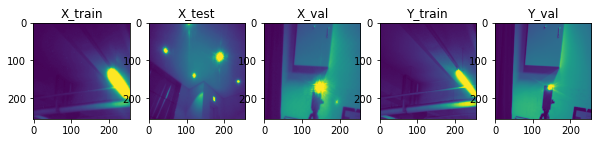

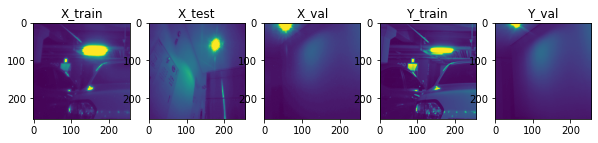

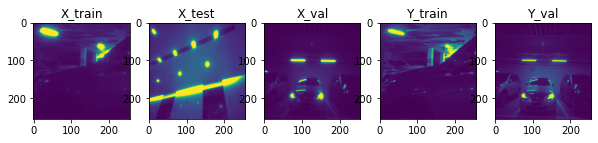

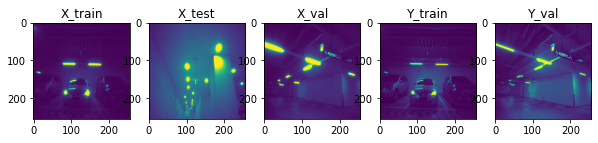

In [12]:
import scipy.signal as signal
for i in range(0, 4):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(151)
    plt.title('X_train')
    plt.imshow(X_train[i])
    fig.add_subplot(152)
    plt.title('X_test')
    plt.imshow(X_test[i])
    fig.add_subplot(153)
    plt.title('X_val')
    plt.imshow(X_val[i])
    fig.add_subplot(154)
    plt.title('Y_train')
    plt.imshow(Y_train[i])
    fig.add_subplot(155)
    plt.title('Y_val')
    plt.imshow(Y_val[i])
    plt.show

## variational autoencoder

https://www.tensorflow.org/tutorials/generative/cvae


https://github.com/bjlkeng/sandbox/blob/master/notebooks/variational-autoencoder.ipynb

In [13]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose,Reshape

In [14]:
%matplotlib inline

batch_size = 24
original_dim = 256 * 256
latent_dim = 16
epochs = 10
epsilon_std = 1.0
noise_factor = 0.3

In [15]:
x_train = X_train
x_test = X_test

In [16]:
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

In [17]:
train_num = x_train.shape[0]
num_train = x_train.shape[0]

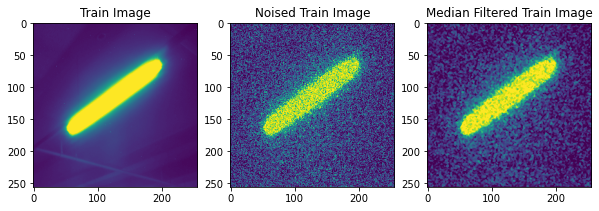

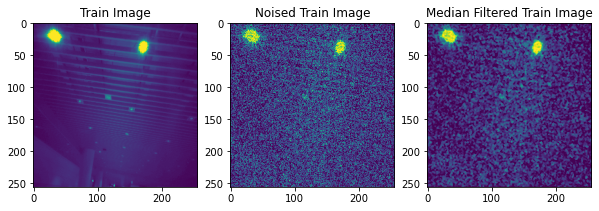

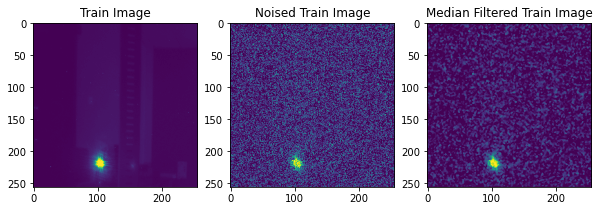

In [18]:
import scipy.signal as signal
for i in range(0, 3):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Train Image')
    plt.imshow(x_train[i])
    fig.add_subplot(132)
    plt.title('Noised Train Image')
    plt.imshow(noise_train[i])
    fig.add_subplot(133)
    plt.title('Median Filtered Train Image')
    plt.imshow(signal.medfilt2d(np.reshape(noise_train[i], [256, 256]),[3,3]))
    plt.show

In [18]:
#encoder part
import tensorflow
x_noise = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(x_noise)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)
h=Flatten()(encoder)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [20]:
Model(x_noise, z).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [19]:
decoder = tensorflow.keras.layers.Dense(32 * 32 * 16, activation = "relu")(z)
decoder = tensorflow.keras.layers.Reshape((32, 32, 16))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

In [20]:
vae = Model(x_noise, decoder_output)

In [21]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

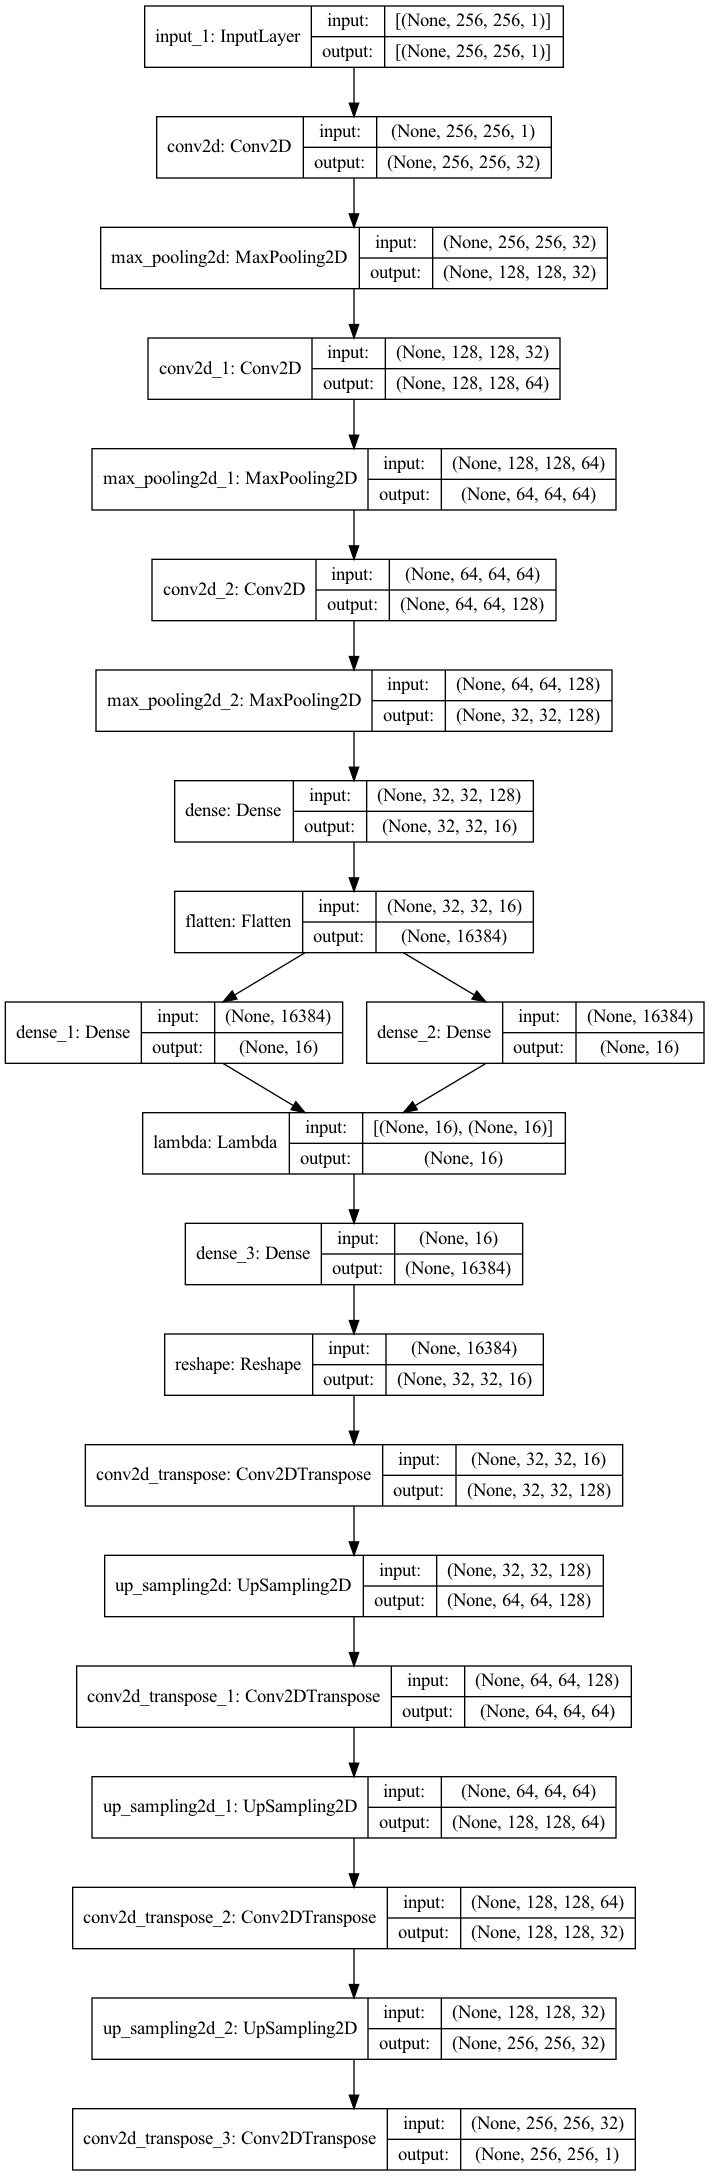

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(vae, to_file='model3.png',show_shapes=True)

In [23]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss / (256 * 256)
vae.compile(optimizer='adam', loss=VAE_loss)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=30)
history = vae.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

In [27]:
Y_test = vae.predict(x_test, batch_size =16)

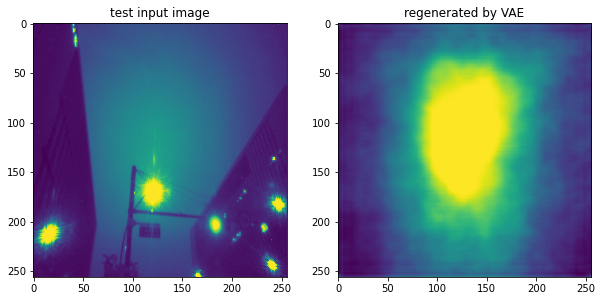

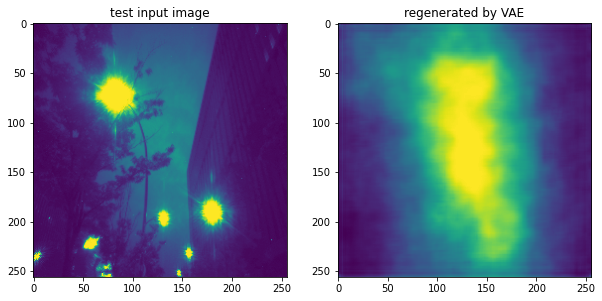

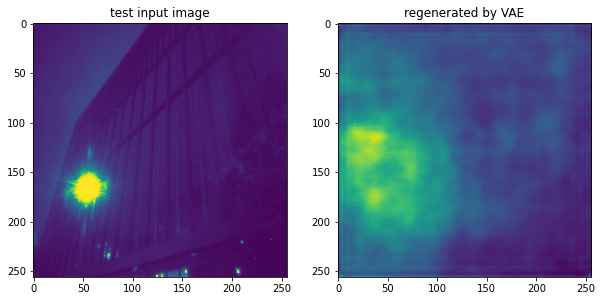

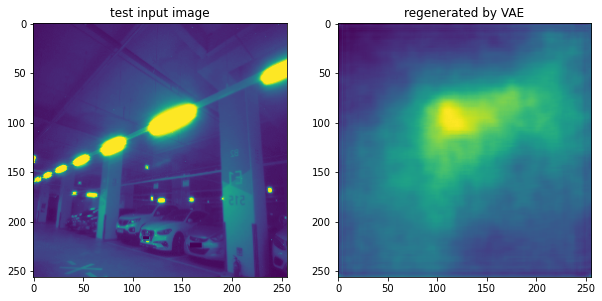

In [28]:
# plots
for i in range(10, 14):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('regenerated by VAE')
    plt.imshow(Y_test[i])
    plt.show

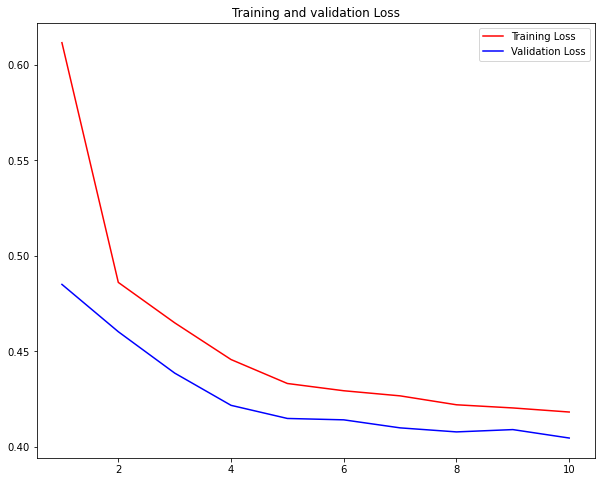

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
max_val_acc=np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

## apply noisy input into the first vae

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=30)
history = vae.fit(noisey, pure, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

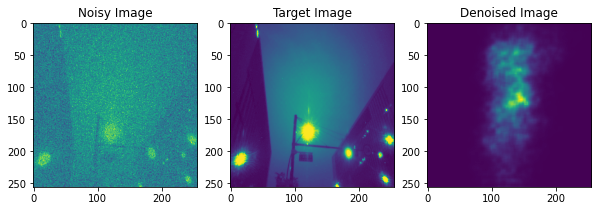

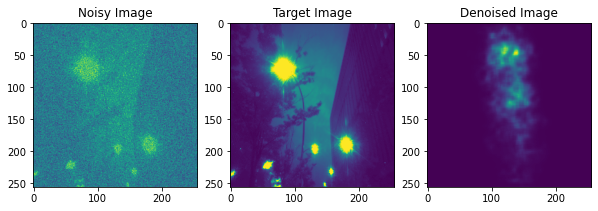

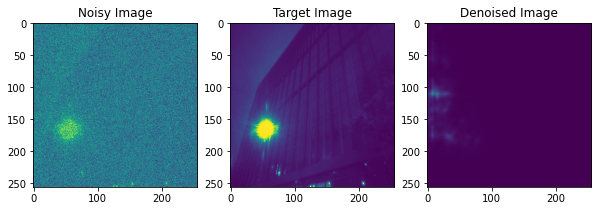

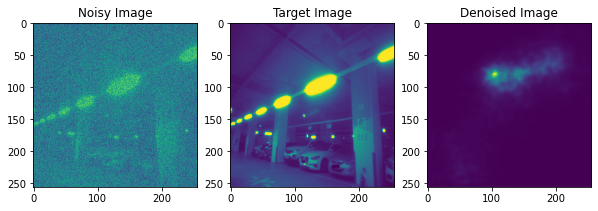

In [35]:
samples = noisy_input_test
targets = X_test
denoised_images = vae.predict(samples)
# plots
for i in range(10, 14):
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Noisy Image')
    plt.imshow(samples[i])
    fig.add_subplot(132)
    plt.title('Target Image')
    plt.imshow(targets[i])
    fig.add_subplot(133)
    plt.title('Denoised Image')
    plt.imshow(denoised_images[i])
    plt.show

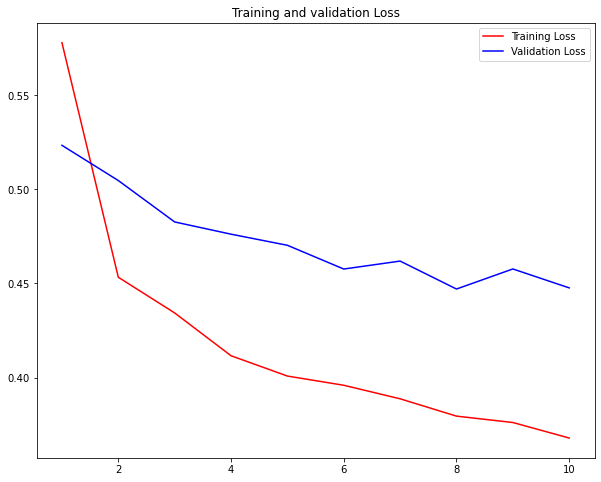

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
max_val_acc=np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

# The second VAE model without maxpooling

In [27]:
#encoder part
import tensorflow
x_noise = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, strides = 2, padding="same", activation='relu')(x_noise)
encoder = tensorflow.keras.layers.Conv2D(64, 3, strides = 2, padding="same", activation='relu')(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, strides = 2, padding="same", activation='relu')(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)
h=Flatten()(encoder)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [28]:
decoder = tensorflow.keras.layers.Dense(32 * 32 * 16, activation = "relu")(z)
decoder = tensorflow.keras.layers.Reshape((32, 32, 16))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, strides = 2, padding="same", activation='relu')(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides = 2, padding="same", activation='relu')(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides = 2, padding="same", activation='relu')(decoder)
decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)


In [29]:
vae2 = Model(x_noise, decoder_output)

In [30]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss / (256 * 256)
vae2.compile(optimizer='adam', loss=VAE_loss)

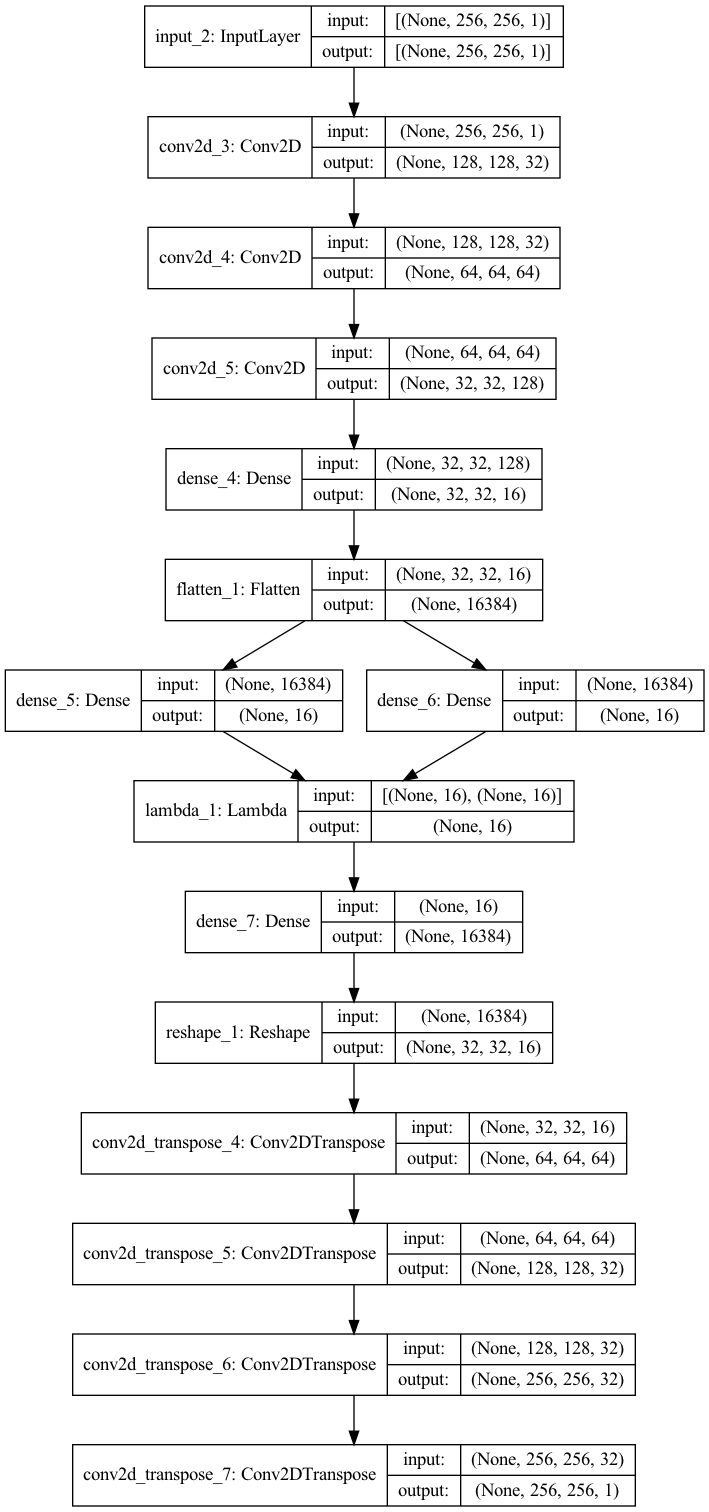

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(vae2, to_file='model3.png',show_shapes=True)

In [32]:
# add noise
pure = X_train
pure_test = X_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

noisey= []
for i in range(0, len(pure)):
    noisey.append(signal.medfilt2d(np.reshape(noise_train[i], [256, 256]),[3,3]))


In [33]:
noisey = np.reshape(noisey, (len(pure) ,256, 256, 1))

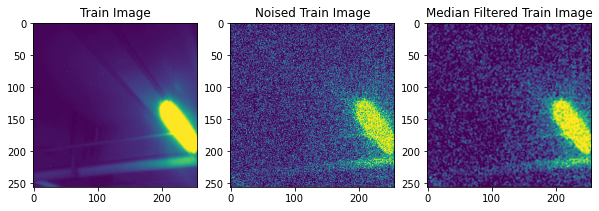

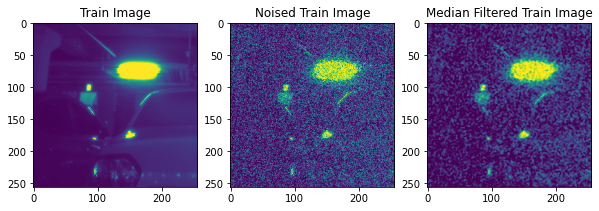

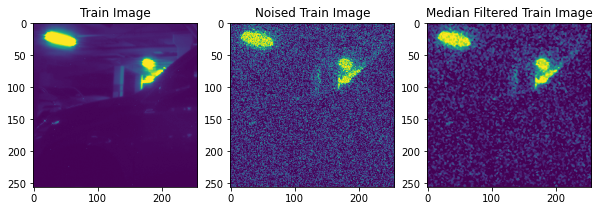

In [37]:
import scipy.signal as signal
for i in range(0, 3):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Train Image')
    plt.imshow(x_train[i])
    fig.add_subplot(132)
    plt.title('Noised Train Image')
    plt.imshow(noise_train[i])
    fig.add_subplot(133)
    plt.title('Median Filtered Train Image')
    plt.imshow(signal.medfilt2d(np.reshape(noise_train[i], [256, 256]),[3,3]))
    plt.show

In [ ]:
# fit the model with train and test dataset

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=30)
hist3 = vae2.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Train on 476 samples, validate on 84 samples
Epoch 1/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.6351 - val_loss: 0.4845
Epoch 2/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4811 - val_loss: 0.4783
Epoch 3/10
476/476 [==============================] - 19s 39ms/sample - loss: 0.4610 - val_loss: 0.4581
Epoch 4/10
476/476 [==============================] - 19s 40ms/sample - loss: 0.4424 - val_loss: 0.4419
Epoch 5/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4319 - val_loss: 0.4362
Epoch 6/10
476/476 [==============================] - 19s 39ms/sample - loss: 0.4268 - val_loss: 0.4317
Epoch 7/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4224 - val_loss: 0.4298
Epoch 8/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4195 - val_loss: 0.4272
Epoch 9/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4175 - val_loss: 0.4257
Epoch 10/10
476/476

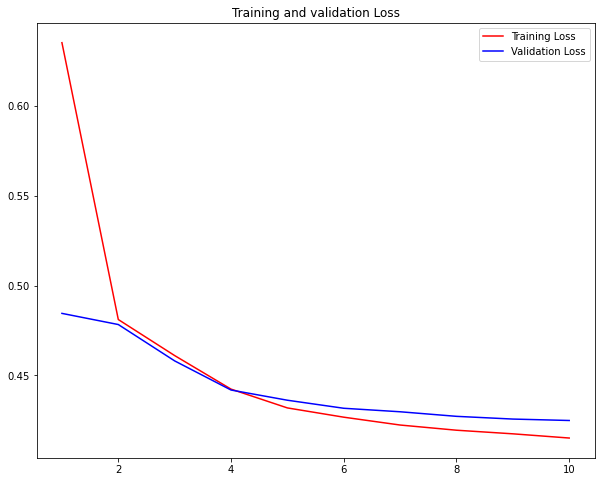

In [39]:
loss = hist3.history['loss']
val_loss = hist3.history['val_loss']
max_val_acc=np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

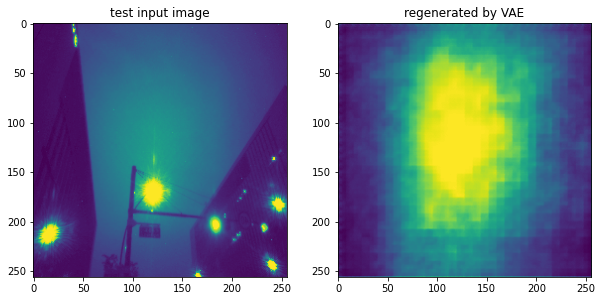

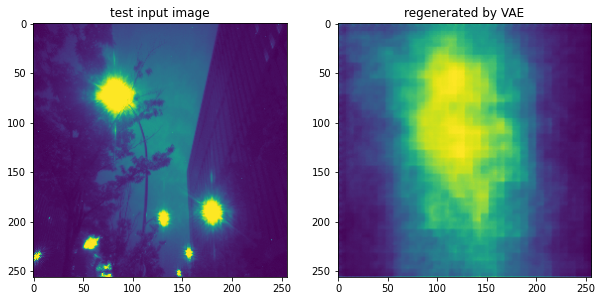

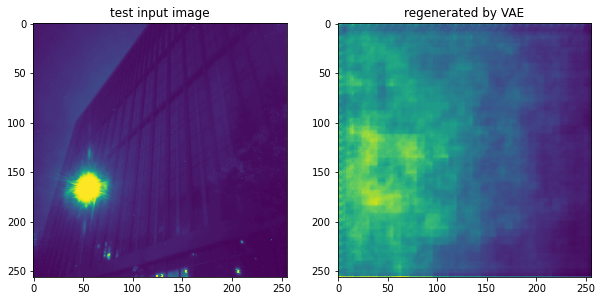

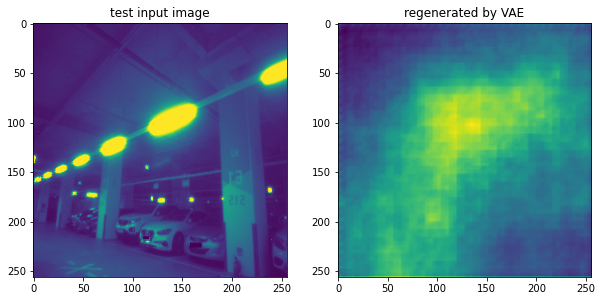

In [40]:
# plots
Y_test = vae2.predict(x_test, batch_size =16)
for i in range(10, 14):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('regenerated by VAE')
    plt.imshow(Y_test[i])
    plt.show

## apply the noisy inputs into the second vae model

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=30)
hist2 = vae2.fit(noisey, pure, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Train on 476 samples, validate on 84 samples
Epoch 1/10
476/476 [==============================] - 19s 40ms/sample - loss: 0.6776 - val_loss: 0.5919
Epoch 2/10
476/476 [==============================] - 18s 39ms/sample - loss: 0.5066 - val_loss: 0.4821
Epoch 3/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4527 - val_loss: 0.4616
Epoch 4/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4405 - val_loss: 0.4417
Epoch 5/10
476/476 [==============================] - 18s 39ms/sample - loss: 0.4234 - val_loss: 0.4289
Epoch 6/10
476/476 [==============================] - 20s 41ms/sample - loss: 0.4094 - val_loss: 0.4226
Epoch 7/10
476/476 [==============================] - 18s 39ms/sample - loss: 0.4044 - val_loss: 0.4217
Epoch 8/10
476/476 [==============================] - 18s 38ms/sample - loss: 0.4009 - val_loss: 0.4214
Epoch 9/10
476/476 [==============================] - 19s 39ms/sample - loss: 0.3987 - val_loss: 0.4181
Epoch 10/10
476/476

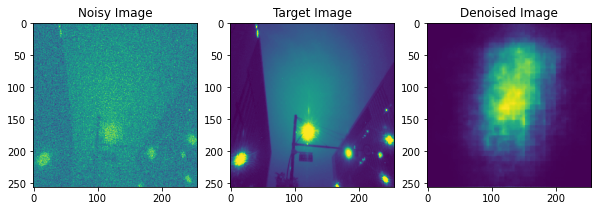

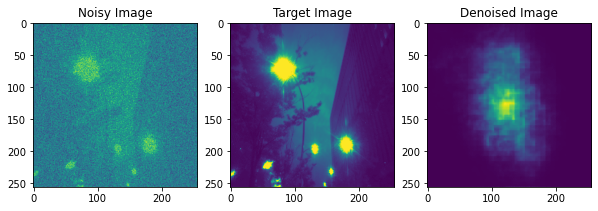

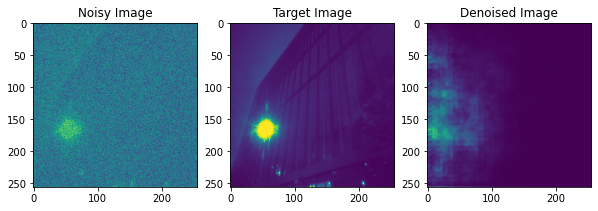

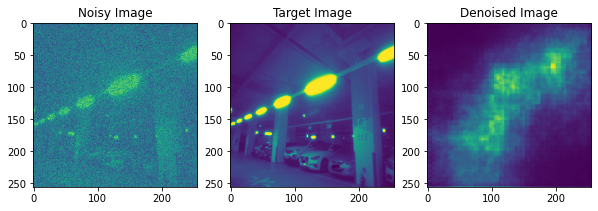

In [39]:
samples = noisy_input_test
targets = X_test
denoised_images = vae2.predict(samples)
# plots
for i in range(10, 14):
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Noisy Image')
    plt.imshow(samples[i])
    fig.add_subplot(132)
    plt.title('Target Image')
    plt.imshow(targets[i])
    fig.add_subplot(133)
    plt.title('Denoised Image')
    plt.imshow(denoised_images[i])
    plt.show

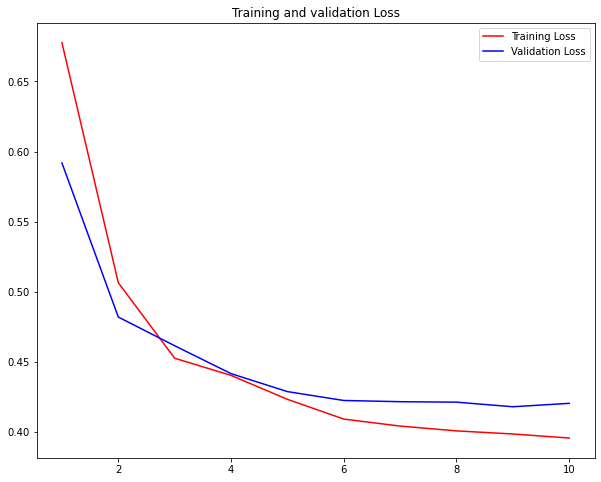

In [40]:
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']
max_val_acc=np.max(val_loss)
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,8))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.show()